In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Get Datasets

In [2]:
# getting training and testing sets from torchvision datasets, downloaded locally on initial run
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [3]:
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


In [4]:
d_train = mnist_trainset.data
d_test = mnist_testset.data

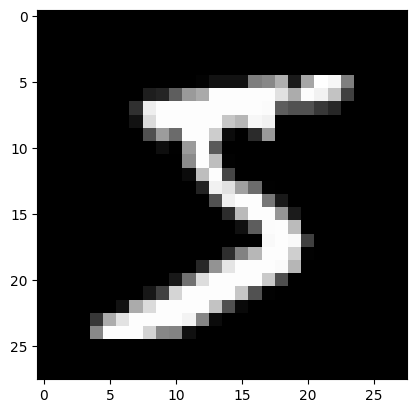

In [5]:
import matplotlib.pyplot as plt
plt.imshow(d_train[0].reshape(28, 28), cmap="gray")

# Define System

In [7]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# set criterion
criterion = nn.CrossEntropyLoss()

cuda:0


In [8]:
BATCH = 60
train_dataloader = DataLoader(mnist_trainset, batch_size=BATCH)
test_dataloader = DataLoader(mnist_testset, batch_size=BATCH)

In [9]:
# train loop for MLP

def train(dataloader, model, criterion, optimizer):
    # get details
    size = len(dataloader.dataset)
    
    # set model to train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        # send data to GPU
        X = X.to(device)
        y = y.to(device)
        
        # get prediction and loss
        pred = model(X)
        loss = criterion(pred, y)

        # update network
        loss.backward()
        optimizer.step()

        # print info at iteration
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, criterion):

    # set model to eval mode
    model.eval()

    # get details
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # vars to hold loss and correct scores
    test_loss = 0
    correct = 0

    # iterate through dataloader, get pred, then update loss and correct
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += criterion(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



# MLP

In [10]:
# simple MLP to classify mnist

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lay1 = nn.Linear(28*28, 800)
        self.lay2 = nn.Linear(800, 800)
        self.lay3 = nn.Linear(800, 10)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 784))
        x = self.lay1(x).relu()
        x = self.lay2(x).relu()
        x = self.lay3(x).relu()
        return x

In [11]:
# instantiate move model to GPU
model = MLP()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
epochs = 10
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train(train_dataloader, model, criterion, optimizer)
    test(test_dataloader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299673  [   60/60000]
loss: 2.295703  [ 6060/60000]
loss: 2.298401  [12060/60000]
loss: 2.288711  [18060/60000]
loss: 2.285659  [24060/60000]
loss: 2.288383  [30060/60000]
loss: 2.286789  [36060/60000]
loss: 2.272788  [42060/60000]
loss: 2.266947  [48060/60000]
loss: 2.277303  [54060/60000]
Test Error: 
 Accuracy: 43.7%, Avg loss: 2.261953 

Epoch 2
-------------------------------
loss: 2.256686  [   60/60000]
loss: 2.239116  [ 6060/60000]
loss: 2.261092  [12060/60000]
loss: 2.243425  [18060/60000]
loss: 2.241206  [24060/60000]
loss: 2.241291  [30060/60000]
loss: 2.249340  [36060/60000]
loss: 2.214871  [42060/60000]
loss: 2.212918  [48060/60000]
loss: 2.236884  [54060/60000]
Test Error: 
 Accuracy: 51.0%, Avg loss: 2.204427 

Epoch 3
-------------------------------
loss: 2.195754  [   60/60000]
loss: 2.157482  [ 6060/60000]
loss: 2.205301  [12060/60000]
loss: 2.180580  [18060/60000]
loss: 2.174786  [24060/60000]
loss: 2.170031  [30060/600

In [13]:
data, label = next(iter(train_dataloader))

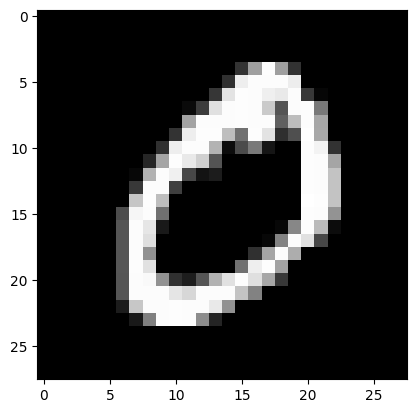

In [19]:
plt.imshow(data[1].reshape(28, 28), cmap="gray")

In [17]:
pred = model(data[1].to(device))

In [18]:
# they are the same!!!!! (also see picture above)

print(pred.argmax(1))
print(label[1])

tensor([0], device='cuda:0')
tensor(0)


# CNN

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # conv layers, 1-->4-->16 channels
        self.c1 = nn.Conv2d(1, 4, 2)
        self.c2 = nn.Conv2d(4, 16, 2)

        # kernel size is 2, stride is 2
        self.pool = nn.MaxPool2d(2, 2)

        # linear layers
        self.lin1 = nn.Linear(576, 500)
        self.lin2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool(self.c1(x).relu())
        x = self.pool(self.c2(x).relu())
        x = torch.flatten(x, 1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return x




In [46]:
# instantiate CNN
cnet = CNN()
cnet.to(device)
optimizer = torch.optim.SGD(cnet.parameters(), lr=1e-3)

In [47]:
epochs = 20
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train(train_dataloader, cnet, criterion, optimizer)
    test(test_dataloader, cnet, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305248  [   60/60000]
loss: 2.301075  [ 6060/60000]
loss: 2.298337  [12060/60000]
loss: 2.290677  [18060/60000]
loss: 2.288820  [24060/60000]
loss: 2.292914  [30060/60000]
loss: 2.290563  [36060/60000]
loss: 2.283379  [42060/60000]
loss: 2.286233  [48060/60000]
loss: 2.299071  [54060/60000]
Test Error: 
 Accuracy: 39.0%, Avg loss: 2.281892 

Epoch 2
-------------------------------
loss: 2.280843  [   60/60000]
loss: 2.279398  [ 6060/60000]
loss: 2.277741  [12060/60000]
loss: 2.273372  [18060/60000]
loss: 2.277988  [24060/60000]
loss: 2.272010  [30060/60000]
loss: 2.271705  [36060/60000]
loss: 2.260207  [42060/60000]
loss: 2.265737  [48060/60000]
loss: 2.281828  [54060/60000]
Test Error: 
 Accuracy: 47.3%, Avg loss: 2.255600 

Epoch 3
-------------------------------
loss: 2.252903  [   60/60000]
loss: 2.248965  [ 6060/60000]
loss: 2.247887  [12060/60000]
loss: 2.244877  [18060/60000]
loss: 2.249072  [24060/60000]
loss: 2.234843  [30060/600